In [ ]:
%matplotlib inline



## dataset 출처  : aihub 한 영 번역 데이터셋 : https://github.com/Huffon/pytorch-transformer-kor-eng



In [ ]:
#이거 실행하고 런타임 다시 시작 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 22 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 2s (5,778 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 128215 files and di

In [ ]:

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 


# 기초부터 시작하는 NLP: Sequence to Sequence 네트워크와 Attention을 이용한 번역
**Author**: [Sean Robertson](https://github.com/spro/practical-pytorch)
  **번역**: [황성수](https://github.com/adonisues)

이 튜토리얼은 "기초부터 시작하는 NLP"의 세번째이자 마지막 편으로, NLP 모델링 작업을
위한 데이터 전처리에 사용할 자체 클래스와 함수들을 작성해보겠습니다.
이 튜토리얼을 마친 뒤에는 `torchtext` 가 어떻게 지금까지의 튜토리얼들에서의
전처리 과정을 다루는지를 이후 튜토리얼들에서 배울 수 있습니다.

이 프로젝트에서는 신경망이 불어를 영어로 번역하도록 가르칠 예정입니다.

::

    [KEY: > input, = target, < output]

    > 나 지금 비행기 표 예약하고 있어.
    = I am booking the plane tickets right now.
    < I am booking the plane right now. <EOS>

    > 너랑 이야기할 수 있어서 피곤하지 않아.
    = I am not tired because I can talk with you.
    < I am not that can I talk with you. <EOS>

    > 지금 처음 써보는 데 버튼 소리가 생각보다 많이 나는데?
    = I am using it for the first time, but there is more noise than I expected.
    < I am using it for the first time but there is more noise <EOS>


    > 그 사람은 지금 녹초가 되는 중이예요.
    = He is getting exhausted right now.
    < He is getting exhausted right now. <EOS>

    > 우리도 비슷한 컨셉의 메뉴를 생각하고 있어.
    = We are considering the similar concept of menu.
    < We are on a the at our our <EOS>



... 성공율은 변할 수 있습니다.

하나의 시퀀스를 다른 시퀀스로 바꾸는 두개의 RNN이 함께 동작하는
[sequence to sequence network](https://arxiv.org/abs/1409.3215)_ 의 간단하지만 강력한 아이디어가
이것(번역)을 가능하게 합니다. 인코더 네트워크는 입력 시퀀스를 벡터로 압축하고,
디코더 네트워크는 해당 벡터를 새로운 시퀀스로 펼칩니다.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

이 모델을 개선하기 위해 [Attention Mechanism](https://arxiv.org/abs/1409.0473)_ 을
사용하면 디코더가 입력 시퀀스의 특정 범위에 집중할 수 있도록 합니다.

**추천 자료:**

최소한 Pytorch를 설치했고, Python을 알고, Tensor를 이해한다고 가정합니다.:

-  http://pytorch.org/ 설치 안내를 위한 자료
-  :doc:`/beginner/deep_learning_60min_blitz` 일반적인 PyTorch 시작을 위한 자료
-  :doc:`/beginner/pytorch_with_examples` 넓고 깊은 통찰을 위한 자료
-  :doc:`/beginner/former_torchies_tutorial` 이전 Lua Torch 사용자를 위한 자료


Sequence to Sequence 네트워크와 동작 방법에 관해서 아는 것은 유용합니다:

-  [Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation](https://arxiv.org/abs/1406.1078)_
-  [Sequence to Sequence Learning with Neural
   Networks](https://arxiv.org/abs/1409.3215)_
-  [Neural Machine Translation by Jointly Learning to Align and
   Translate](https://arxiv.org/abs/1409.0473)_
-  [A Neural Conversational Model](https://arxiv.org/abs/1506.05869)_

이전 튜토리얼에 있는
:doc:`/intermediate/char_rnn_classification_tutorial`
와 :doc:`/intermediate/char_rnn_generation_tutorial` 는
각각 인코더, 디코더 모델과 비슷한 컨센을 가지기 때문에 도움이 됩니다.

**요구 사항**


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import numpy as np
import sys 

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch.autograd import Variable
Variable(torch.LongTensor([1] * 10)).shape

torch.Size([10])

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!mkdir -p /drive

#umount /drive
!mount --bind /content/drive/My\ Drive /drive


Mounted at /content/drive


## 데이터 파일 로딩

이 프로젝트의 데이터는 수천 개의 영어-프랑스어 번역 쌍입니다.

[Open Data Stack Exchange](https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages)_
에 관한 이 질문은 https://tatoeba.org/eng/downloads 에서 다운 로드가 가능한
공개 번역 사이트 https://tatoeba.org/ 를 알려 주었습니다. 더 나은 방법으로
언어 쌍을 개별 텍스트 파일로 분할하는 추가 작업을 수행한
https://www.manythings.org/anki/ 가 있습니다:

영어-프랑스어 쌍이 너무 커서 저장소에 포함 할 수 없기 때문에
계속하기 전에 ``data/eng-fra.txt`` 로 다운로드하십시오.
이 파일은 탭으로 구분된 번역 쌍 목록입니다:

::

    I am cold.    J'ai froid.

.. Note::
   [여기](https://download.pytorch.org/tutorial/data.zip)
   에서 데이터를 다운 받고 현재 디렉토리에 압축을 푸십시오.



문자 단위 RNN 튜토리얼에서 사용된 문자 인코딩과 유사하게, 언어의 각
단어들을 One-Hot 벡터 또는 그 단어의 주소에만 단 하나의 1을 제외하고
모두 0인 큰 벡터로 표현합니다. 한 가지 언어에 있는 수십 개의 문자와
달리 번역에는 아주 많은 단어들이 있기 때문에 인코딩 벡터는 매우 더 큽니다.
그러나 우리는 약간의 트릭를 써서 언어 당 수천 단어 만
사용하도록 데이터를 다듬을 것입니다.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:





나중에 네트워크의 입력 및 목표로 사용하려면 단어 당 고유 번호가
필요합니다. 이 모든 것을 추적하기 위해 우리는
단어→색인(``word2index``)과 색인→단어(``index2word``) 사전,
그리고 나중에 희귀 단어를 대체하는데 사용할 각 단어의 빈도
``word2count`` 를 가진 ``Lang`` 이라는 헬퍼 클래스를 사용합니다.




In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS 와 EOS 포함

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

파일은 모두 유니 코드로 되어있어 간단하게하기 위해 유니 코드 문자를
ASCII로 변환하고, 모든 문자를 소문자로 만들고, 대부분의 구두점을
지워줍니다.




In [ ]:
# 유니 코드 문자열을 일반 ASCII로 변환하십시오.불어 독어 악센트 제거 
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거


def normalizeString(s):
    #s = unicodeToAscii(s.strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [ ]:
valid_data = pd.read_csv("/content/drive/MyDrive/패스트캠퍼스강의/실습자료/data/kor-eng.csv", encoding='utf-8')

In [ ]:
valid_data


,korean,english
0,나는 매일 저녁 배트를 만나러 다락방으로 가요.,I go to the attic every evening to meet Bat.
1,선생님 이문장이 이해가 안 가요.,"Sir, I don't understand this sentence here."
2,컴퓨터를 시작하면 시간이 너무 빠르게 가요.,Time flies when you start using the computer.
3,나는 오늘 자정에 한국으로 돌아 가요.,I'm going back to Korea today at midnight.
4,나는 일어나자마자 화장실에 가요.,I go to bathroom as soon as I wake up.
...,...,...
114995,잘은 기억 안 나지만 내 동생이 가고 싶어 한 것 같기도 한데.,"I don't remember exactly, but I think my broth..."
114996,제가 비행기 예약한 지 24시간이 안 지났는데 환불되죠?,It's been less than 24 hours since I booked my...
114997,아직은 가능하십니다만 저희 규정상 동의서가 필요합니다.,"It's still possible, but our according to our ..."
114998,지금 바로 쓸 테니 펜하고 양식 한 장만 부탁해요.,"I'll fill it out it right now, so please let m..."


In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 파일을 읽고 줄로 분리
    valid_data = pd.read_csv("/content/drive/MyDrive/패스트캠퍼스강의/실습자료/data/kor-eng.csv", encoding='utf-8')
    #lines = open('/content/drive/MyDrive/패스트캠퍼스강의/실습자료/data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
    #    read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화
    #pairs = [[normalizeString(s) for s in l.strip().split('\t')] for l in lines]
    pairs = list(zip(valid_data['english'].to_list(), valid_data['korean'].to_list()))

    # 쌍을 뒤집고, Lang 인스턴스 생성
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

*많은* 예제 문장이 있고 신속하게 학습하기를 원하기 때문에
비교적 짧고 간단한 문장으로만 데이터 셋을 정리할 것입니다. 여기서
최대 길이는 10 단어 (종료 문장 부호 포함)이며 "I am" 또는
"He is" 등의 형태로 번역되는 문장으로 필터링됩니다.(이전에
아포스트로피는 대체 됨)




In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    if len(p)!=2:
        return False
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].lower().startswith(eng_prefixes)


def filterPairs(pairs):

    return [pair for pair in pairs if filterPair(pair)]

데이터 준비를 위한 전체 과정:

-  텍스트 파일을 읽고 줄로 분리하고, 줄을 쌍으로 분리합니다.
-  텍스트를 정규화 하고 길이와 내용으로 필터링 합니다.
-  쌍을 이룬 문장들로 단어 리스트를 생성합니다.




In [ ]:
input_lang, output_lang, pairs = readLangs('kor', 'eng', False)

Reading lines...


In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print(len(pairs))
    print(pairs[0])
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('kor', 'eng', True)
print(random.choice(pairs))

Reading lines...
Read 115000 sentence pairs
115000
['나는 매일 저녁 배트를 만나러 다락방으로 가요.', 'I go to the attic every evening to meet Bat.']
Trimmed to 1614 sentence pairs
Counting words...
Counted words:
eng 4177
kor 2922
['그들은 한국인과 중국인으로 구성되어 있는 팀이예요.', 'They are the team consisted of Koreans and Chinese.']


## Seq2Seq 모델

Recurrent Neural Network(RNN)는 시퀀스에서 작동하고 다음 단계의
입력으로 자신의 출력을 사용하는 네트워크입니다.

[Sequence to Sequence network](https://arxiv.org/abs/1409.3215)_, 또는
Seq2Seq 네트워크, 또는 [Encoder Decoder
network](https://arxiv.org/pdf/1406.1078v3.pdf)_ 는 인코더 및
디코더라고 하는 두 개의 RNN으로 구성된 모델입니다.
인코더는 입력 시퀀스를 읽고 단일 벡터를 출력하고,
디코더는 해당 벡터를 읽어 출력 시퀀스를 생성합니다.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

모든 입력에 해당하는 출력이 있는 단일 RNN의 시퀀스 예측과 달리
Seq2Seq 모델은 시퀀스 길이와 순서를 자유롭게하기 때문에
두 언어 사이의 번역에 이상적입니다.

다음 문장 "Je ne suis pas le chat noir" → "I am not the black cat"
를 살펴 봅시다. 입력 문장의 단어 대부분은 출력 문장에서
직역("chat noir" 와 "black cat")되지만 약간 다른 순서도 있습니다.
"ne/pas" 구조로 인해 입력 문장에 단어가 하나 더 있습니다.
입력 단어의 시퀀스를 직역해서 정확한 번역을 만드는
것은 어려울 것입니다.

Seq2Seq 모델을 사용하면 인코더는 하나의 벡터를 생성합니다.
이상적인 경우에 입력 시퀀스의 "의미"를 문장의 N 차원 공간에 있는
단일 지점인 단일 벡터으로 인코딩합니다.




### 인코더

Seq2Seq 네트워크의 인코더는 입력 문장의 모든 단어에 대해 어떤 값을
출력하는 RNN입니다. 모든 입력 단어에 대해 인코더는 벡터와
은닉 상태를 출력하고 다음 입력 단어를 위해 그 은닉 상태를 사용합니다.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        #input = (1)
        embedded = self.embedding(input).view(1, 1, -1) # (len, batch, hidden)
        output = embedded
        output, hidden = self.gru(output, hidden) # (len, batch, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 디코더

디코더는 인코더 출력 벡터를 받아서 번역을 생성하기 위한 단어 시퀀스를
출력합니다.




#### 간단한 디코더

가장 간단한 Seq2Seq 디코더는 인코더의 마지막 출력만을 이용합니다.
이 마지막 출력은 전체 시퀀스에서 문맥을 인코드하기 때문에
*문맥 벡터(context vector)* 로 불립니다. 이 문맥 벡터는 디코더의 초기 은닉 상태로
사용 됩니다.

디코딩의 매 단계에서 디코더에게 입력 토큰과 은닉 상태가 주어집니다.
초기 입력 토큰은 문자열-시작 (start-of-string) ``<SOS>`` 토큰이고,
첫 은닉 상태는 문맥 벡터(인코더의 마지막 은닉 상태) 입니다.

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1) # (N, L, D)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden) # (N, L, D)
        output = self.softmax(self.out(output[0])) 
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

이 모델의 결과를 학습하고 관찰하는 것을 권장하지만,
공간을 절약하기 위해 최종 목적지로 바로 이동해서
Attention 메커니즘을 소개 할 것입니다.




#### Attention 디코더

문맥 벡터만 인코더와 디코더 사이로 전달 된다면, 단일 벡터가 전체 문장을
인코딩 해야하는 부담을 가지게 됩니다.

Attention은 디코더 네트워크가 자기 출력의 모든 단계에서 인코더 출력의
다른 부분에 "집중" 할 수 있게 합니다. 첫째 *Attention 가중치* 의 세트를
계산합니다. 이것은 가중치 조합을 만들기 위해서 인코더 출력 벡터와
곱해집니다. 그 결과(코드에서 ``attn_applied``)는 입력 시퀀스의
특정 부분에 관한 정보를 포함해야하고 따라서 디코더가 알맞은 출력
단어를 선택하는 것을 도와줍니다.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

어텐션 가중치 계산은 디코더의 입력 및 은닉 상태를 입력으로
사용하는 다른 feed-forwad 계층인 ``attn`` 으로 수행됩니다.
학습 데이터에는 모든 크기의 문장이 있기 때문에 이 계층을 실제로
만들고 학습시키려면 적용 할 수 있는 최대 문장 길이 (인코더 출력을 위한 입력 길이)를
선택해야 합니다. 최대 길이의 문장은 모든 Attention 가중치를 사용하지만
더 짧은 문장은 처음 몇 개만 사용합니다.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





In [ ]:


def sequence_mask(sequence_length, max_len=None, use_cuda=False):
    if isinstance(sequence_length, np.ndarray):
        sequence_length = Variable(torch.from_numpy(sequence_length))
    elif isinstance(sequence_length, list):
        sequence_length = Variable(torch.from_numpy(np.array(sequence_length)))

    if max_len is None:
        max_len = sequence_length.data.max()

    batch_size = sequence_length.size(0)
    seq_range = torch.arange(0, max_len).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    if sequence_length.is_cuda:
        seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    mask = seq_range_expand < seq_length_expand # [0,1,2,3,4,5] < [4,4,4,4,4,4]
    if use_cuda:
        mask = mask.cuda()
    return mask


In [ ]:
torch.Tensor([1,2,3,4,5,6]).view(1,6,1)

tensor([[[1.],
         [2.],
         [3.],
         [4.],
         [5.],
         [6.]]])

In [ ]:
torch.Tensor([1,2,3,4,5,6]).view(1,6,1).permute(1,2,0)

tensor([[[1.]],

        [[2.]],

        [[3.]],

        [[4.]],

        [[5.]],

        [[6.]]])

In [ ]:
(0.25)**0.5

0.5

In [ ]:
class BahdanauDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH, score_function = "general"):
        super(BahdanauDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.score_function = score_function
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        if self.score_function == "general":
          self.W = nn.Linear(self.hidden_size, self.hidden_size)
        elif self.score_function == "concat":
          #additive
          self.W = nn.Linear(2 * self.hidden_size, self.hidden_size)
          self.V = nn.Linear(self.hidden_size, 1)
        else:
          #dot
          pass
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs, input_len):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        #encoder_outputs.shape = ( max_seq, hidden)

        if self.score_function == "general": 
          attn_weights =  torch.bmm(self.W(hidden).transpose(1, 0), encoder_outputs.unsqueeze(1).permute(1, 2, 0)) # (1,batch,hidden) @ ( 1, hidden, max_seq) -->  (1, batch (= 1), max_seq) 
        elif self.score_function == "concat":

          attn_weights = torch.tanh(self.W(torch.cat((hidden.repeat(1, self.max_length, 1) , encoder_outputs.unsqueeze(0)), dim=2))) # (1, max_seq, 2*hidden) --> (1, max_seq, hidden)
          attn_weights = self.V(attn_weights) #  (1, max_seq, 1)
          attn_weights = attn_weights.transpose(1,2)#  (1, max_seq, 1) --->(1, 1, max_length)
        else:
          attn_weights =  torch.bmm(hidden.transpose(1, 0), encoder_outputs.unsqueeze(1).permute(1, 2, 0)) # (1,1,hidden) @ ( 1, hidden, max_seq) -->  (1, 1, max_seq) 

        attn_mask = sequence_mask([input_len],self.max_length, use_cuda = torch.cuda.is_available()).unsqueeze(0).float() # (1, 1, max_seq) 
        attn_mask = (attn_mask - 1.0) * sys.maxsize

        attn_weights = F.softmax((attn_weights+attn_mask)/self.hidden_size**0.5, dim=-1) #(1, 1, max_length)
        #attn_weights = F.softmax(
        #                torch.bmm(hidden.transpose(1, 0), encoder_outputs.unsqueeze(0).permute(0,2,1)), # (1, 1, hidden)  @ ( 1, hidden, max_length) = (1, 1, max_length)
        #              dim=-1)
        context_vector = torch.bmm(attn_weights, 
                                 encoder_outputs.unsqueeze(0)) # (1, 1, max_length)  @ (1, max_length, hidden) = (1, 1, hidden)

        input_vec = torch.cat((embedded[0], context_vector[0]), 1) #(1,hidden) -->(1,2*hidden)
        input_vec = self.attn_combine(input_vec).unsqueeze(0) #(1,2*hidden) -->(1, 1,hidden)
        input_vec = F.relu(input_vec)
        output, hidden = self.gru(input_vec, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1) #(1, vocab)
        return output, hidden, attn_weights # (1, vocab), (1,1,hidden), (1,len)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1) #(1,hidden) -->(1,2*hidden) --> (1,max_length)
        context_vector = torch.bmm(attn_weights.unsqueeze(0), # (1, 1, max_length)  @ (1, max_length, hidden) = (1, 1, hidden)
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], context_vector[0]), 1) #(1,hidden) -->(1,2*hidden)
        output = self.attn_combine(output).unsqueeze(0) #(1,2*hidden) -->(1,hidden) -->(1,1, hidden)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden) # #(1,1 ,hidden) , (1,hidden)

        output = F.log_softmax(self.out(output[0]), dim=1) #(1,1 ,hidden) --> (1,hidden) --> (1, vocab)
        return output, hidden, attn_weights # (1, vocab), (1,1,hidden), (1,len)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in [Effective Approaches to Attention-based Neural Machine
  Translation](https://arxiv.org/abs/1508.04025)_.</p></div>

## 학습

### 학습 데이터 준비

학습을 위해서, 각 쌍마다 입력 Tensor(입력 문장의 단어 주소)와
목표 Tensor(목표 문장의 단어 주소)가 필요합니다. 이 벡터들을
생성하는 동안 두 시퀀스에 EOS 토큰을 추가 합니다.




In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1) # ( L+1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### 모델 학습

학습을 위해서 인코더에 입력 문장을 넣고 모든 출력과 최신 은닉 상태를
추적합니다. 그런 다음 디코더에 첫 번째 입력으로 ``<SOS>`` 토큰과
인코더의 마지막 은닉 상태가 첫번쩨 은닉 상태로 제공됩니다.

"Teacher forcing"은 다음 입력으로 디코더의 예측을 사용하는 대신
실제 목표 출력을 다음 입력으로 사용하는 컨셉입니다.
"Teacher forcing"을 사용하면 수렴이 빨리되지만 [학습된 네트워크가
잘못 사용될 때 불안정성을 보입니다.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf)_.

Teacher-forced 네트워크의 출력이 일관된 문법으로 읽지만 정확한
번역과는 거리가 멀다는 것을 볼 수 있습니다. 직관적으로 출력 문법을
표현하는 법을 배우고 교사가 처음 몇 단어를 말하면 의미를 "선택" 할 수 있지만,
번역에서 처음으로 문장을 만드는 법은 잘 배우지 못합니다.

PyTorch의 autograd 가 제공하는 자유 덕분에 간단한 If 문으로
Teacher Forcing을 사용할지 아니면 사용하지 않을지를 선택할 수 있습니다.
더 많이 사용하려면 ``teacher_forcing_ratio`` 를 확인하십시오.




In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden) #encoder_output = ( seq, batch, hidden) , encoder_hidden = ( 1, batch, hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing 포함: 목표를 다음 입력으로 전달
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder( # 
                decoder_input, decoder_hidden, encoder_outputs, input_length)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Teacher forcing 미포함: 자신의 예측을 다음 입력으로 사용
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs,  input_length)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()
    
    # Clip gradients
    _ = torch.nn.utils.clip_grad_norm(encoder.parameters(), 5.0)
    _ = torch.nn.utils.clip_grad_norm(decoder.parameters(), 5.0)

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

이것은 현재 시간과 진행률%을 고려해 경과된 시간과 남은 예상
시간을 출력하는 헬퍼 함수입니다.




In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

전체 학습 과정은 다음과 같습니다:

-  타이머 시작
-  optimizers와 criterion 초기화
-  학습 쌍의 세트 생성
-  도식화를 위한 빈 손실 배열 시작

그런 다음 우리는 여러 번 ``train`` 을 호출하며 때로는 진행률
(예제의 %, 현재까지의 예상 시간)과 평균 손실을 출력합니다.




In [ ]:
%matplotlib inline

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate* 5.0)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            evaluateAndShowAttention("너희 들은 영어도 못하고 한국말도 못해.")


        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### 결과 도식화

matplotlib로 학습 중에 저장된 손실 값 ``plot_losses`` 의 배열을
사용하여 도식화합니다.




In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## 평가

평가는 대부분 학습과 동일하지만 목표가 없으므로 각 단계마다 디코더의
예측을 되돌려 전달합니다.
단어를 예측할 때마다 그 단어를 출력 문자열에 추가합니다.
만약 EOS 토큰을 예측하면 거기에서 멈춥니다.
나중에 도식화를 위해서 디코더의 Attention 출력을 저장합니다.




In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], # [1]
                                                     encoder_hidden) # (len, batch, hidden) = (1, 1, hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden # (len, batch, hidden) = (1, 1, hidden)

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder( 
                decoder_input, decoder_hidden, encoder_outputs,input_length)
            decoder_attentions[di] = decoder_attention.detach() # (max_leng)
            topv, topi = decoder_output.detach().topk(1) #(1,vocab) -->(1,1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

학습 세트에 있는 임의의 문장을 평가하고
입력, 목표 및 출력을 출력하여 주관적인 품질 판단을 내릴 수 있습니다:




In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

<ipython-input-20-79052d8e75e7>:50: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  _ = torch.nn.utils.clip_grad_norm(encoder.parameters(), 5.0)
<ipython-input-20-79052d8e75e7>:51: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  _ = torch.nn.utils.clip_grad_norm(decoder.parameters(), 5.0)


0m 27s (- 34m 31s) (1000 1%) 4.3734
input = 너희 들은 영어도 못하고 한국말도 못해.
output = We are going to to the <EOS>


<ipython-input-27-2c69e15d8509>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-27-2c69e15d8509>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


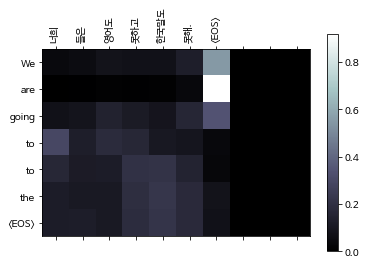

0m 54s (- 33m 19s) (2000 2%) 4.2773
input = 너희 들은 영어도 못하고 한국말도 못해.
output = I am going to the the <EOS>


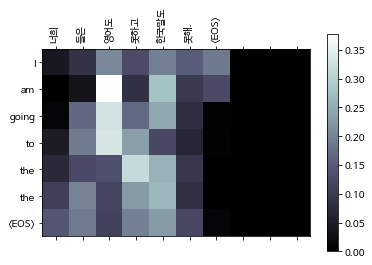

1m 22s (- 32m 50s) (3000 4%) 4.0104
input = 너희 들은 영어도 못하고 한국말도 못해.
output = I am going to the the <EOS>


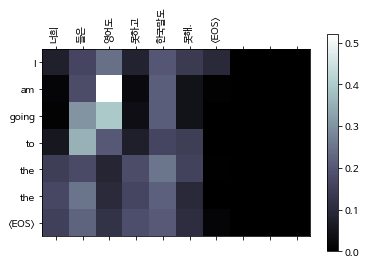

1m 45s (- 31m 13s) (4000 5%) 3.7738
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are going to discuss the development <EOS>


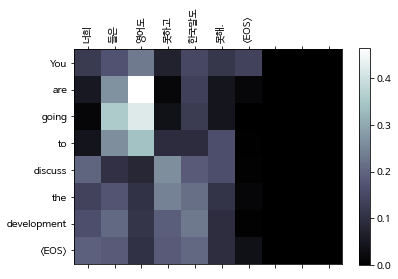

2m 10s (- 30m 22s) (5000 6%) 3.6232
input = 너희 들은 영어도 못하고 한국말도 못해.
output = We are going to have to study <EOS>


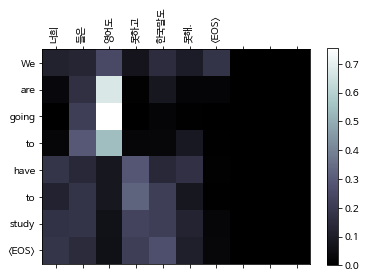

2m 35s (- 29m 46s) (6000 8%) 3.3655
input = 너희 들은 영어도 못하고 한국말도 못해.
output = We are going to deposit valuables from your <EOS>


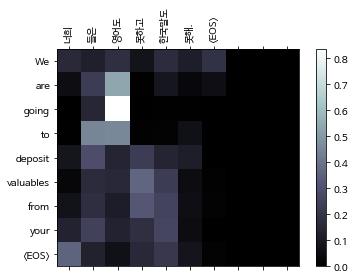

3m 0s (- 29m 15s) (7000 9%) 3.1364
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are going to meet after Capture. <EOS>


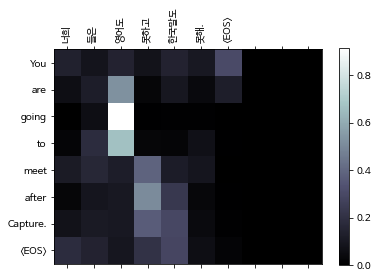

3m 26s (- 28m 45s) (8000 10%) 2.9579
input = 너희 들은 영어도 못하고 한국말도 못해.
output = We are going to study and night. <EOS>


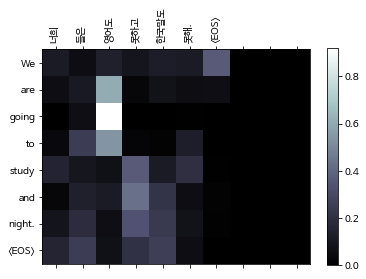

3m 52s (- 28m 26s) (9000 12%) 2.7743
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are going to sing your explanation. <EOS>


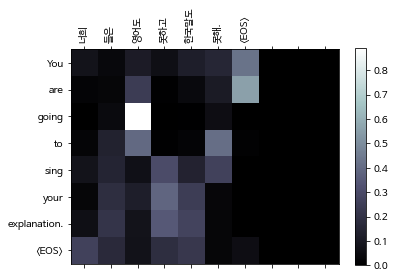

4m 18s (- 27m 58s) (10000 13%) 2.5244
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are not to be and thank you. <EOS>


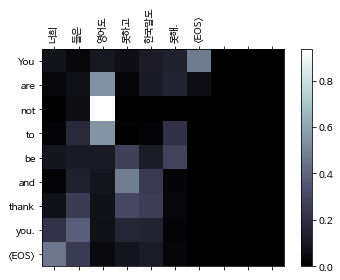

4m 43s (- 27m 31s) (11000 14%) 2.2694
input = 너희 들은 영어도 못하고 한국말도 못해.
output = They are going to change the design and stolen <EOS>


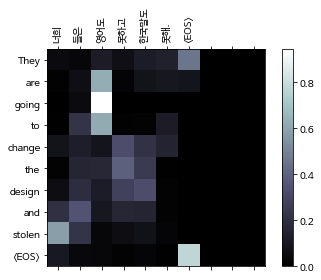

5m 9s (- 27m 6s) (12000 16%) 2.0947
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are not to deposit your <EOS>


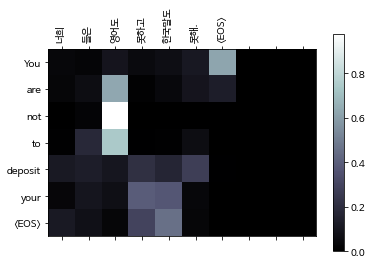

5m 34s (- 26m 37s) (13000 17%) 1.8268
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are more to Korea and empathy. <EOS>


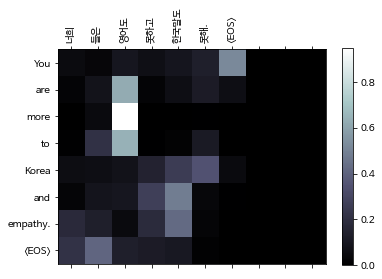

6m 2s (- 26m 21s) (14000 18%) 1.6496
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are not allowed to yourself. <EOS>


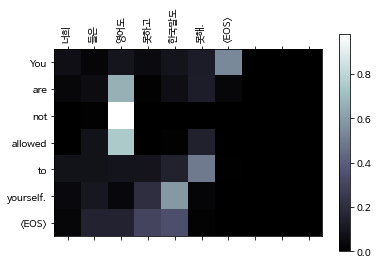

6m 29s (- 25m 58s) (15000 20%) 1.4341
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are absolutely going to ask me <EOS>


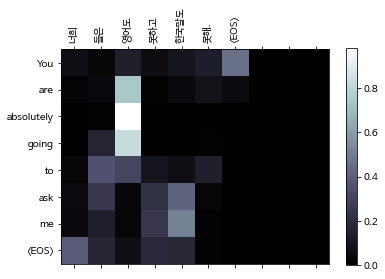

6m 56s (- 25m 34s) (16000 21%) 1.3462
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are always to get your family <EOS>


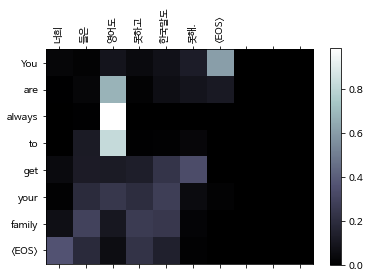

7m 22s (- 25m 10s) (17000 22%) 1.1868
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are also addicted to do English grammar? <EOS>


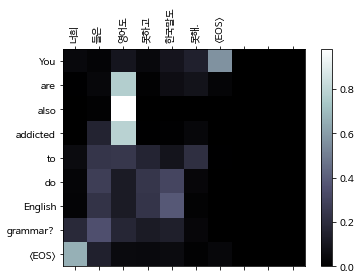

7m 49s (- 24m 45s) (18000 24%) 1.0357
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


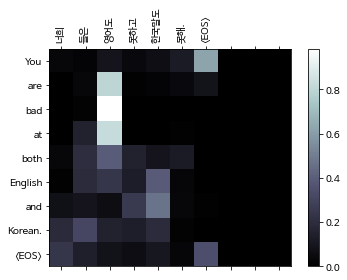

8m 17s (- 24m 26s) (19000 25%) 0.8583
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are not going to do me photos. <EOS>


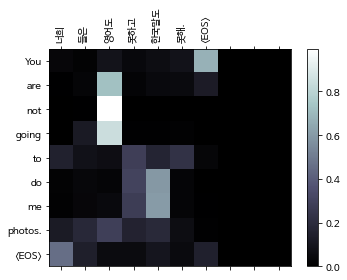

8m 44s (- 24m 2s) (20000 26%) 0.7969
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


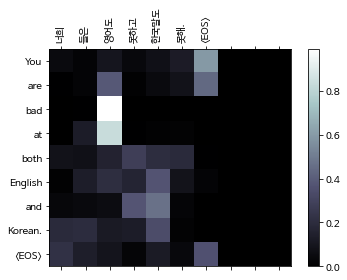

9m 11s (- 23m 38s) (21000 28%) 0.6762
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


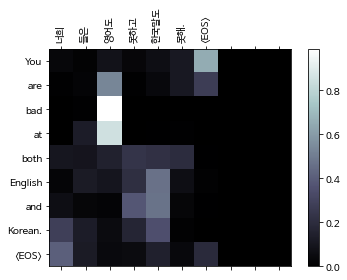

9m 38s (- 23m 12s) (22000 29%) 0.6297
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


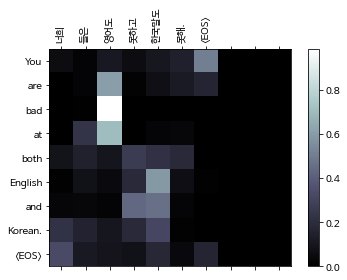

10m 5s (- 22m 48s) (23000 30%) 0.5090
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


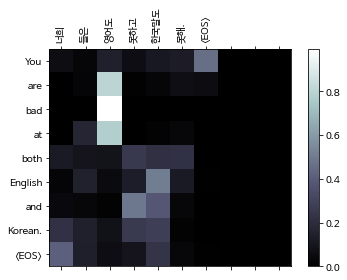

10m 34s (- 22m 27s) (24000 32%) 0.4664
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


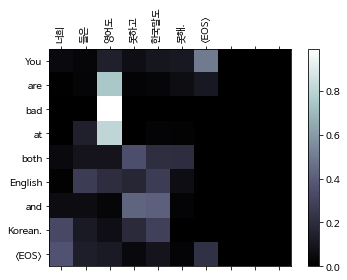

11m 1s (- 22m 2s) (25000 33%) 0.3492
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


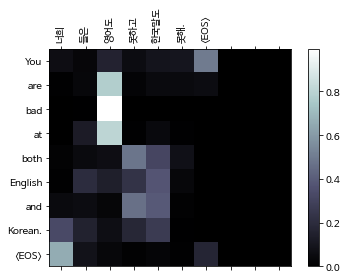

11m 28s (- 21m 37s) (26000 34%) 0.3063
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


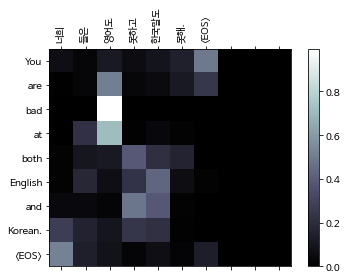

11m 55s (- 21m 12s) (27000 36%) 0.2479
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


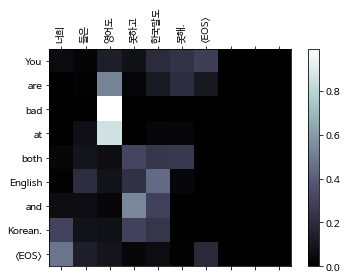

12m 23s (- 20m 47s) (28000 37%) 0.2536
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


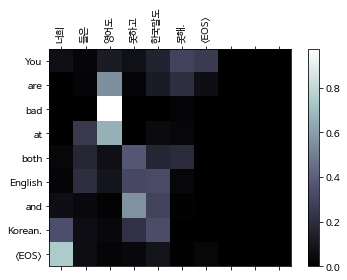

12m 52s (- 20m 25s) (29000 38%) 0.1591
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


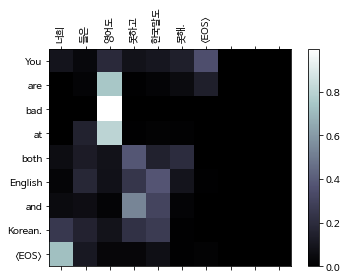

13m 20s (- 20m 0s) (30000 40%) 0.1448
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


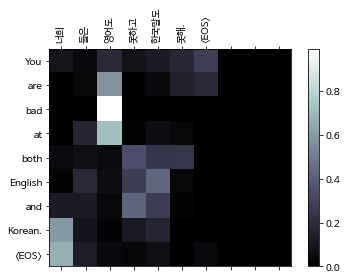

13m 47s (- 19m 35s) (31000 41%) 0.1308
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


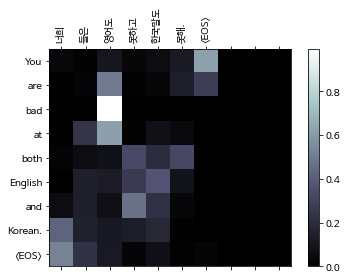

14m 15s (- 19m 9s) (32000 42%) 0.1504
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


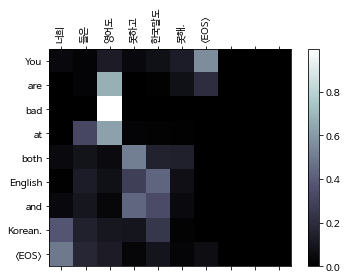

14m 42s (- 18m 43s) (33000 44%) 0.1036
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


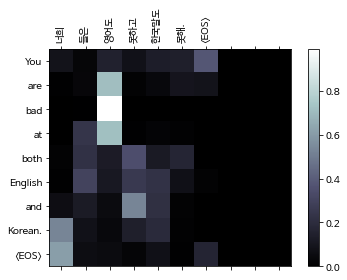

15m 9s (- 18m 16s) (34000 45%) 0.1142
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


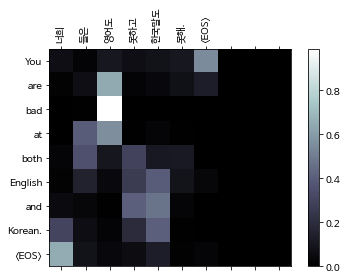

15m 39s (- 17m 53s) (35000 46%) 0.0722
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


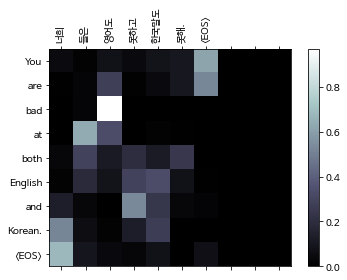

16m 6s (- 17m 26s) (36000 48%) 0.0657
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


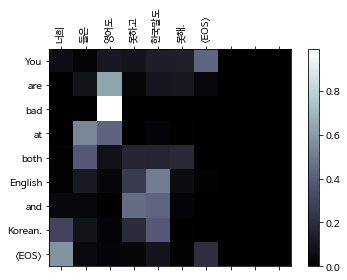

16m 33s (- 17m 0s) (37000 49%) 0.0704
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


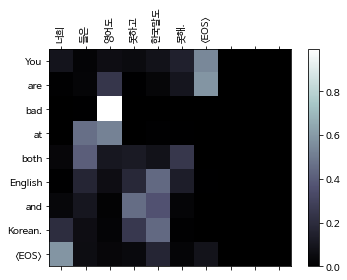

17m 0s (- 16m 33s) (38000 50%) 0.0483
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


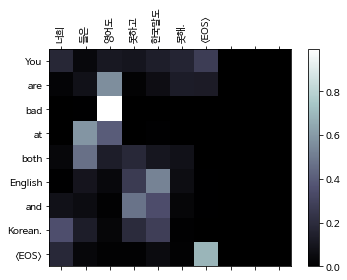

17m 25s (- 16m 5s) (39000 52%) 0.0575
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


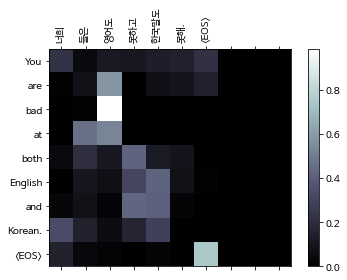

17m 53s (- 15m 39s) (40000 53%) 0.0418
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


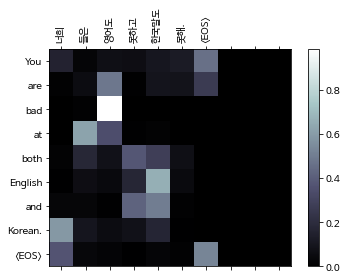

18m 20s (- 15m 12s) (41000 54%) 0.0388
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


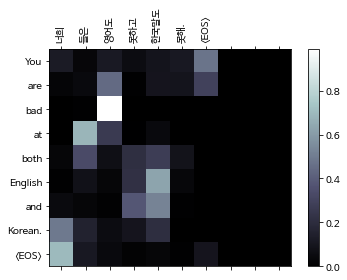

18m 47s (- 14m 45s) (42000 56%) 0.0497
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


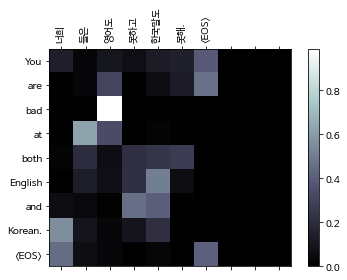

19m 17s (- 14m 21s) (43000 57%) 0.0324
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


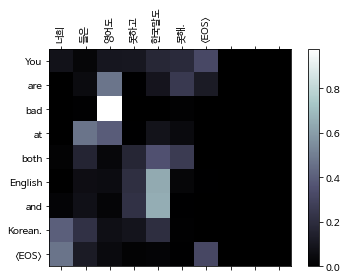

19m 44s (- 13m 54s) (44000 58%) 0.0346
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


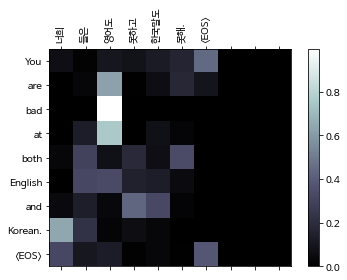

20m 13s (- 13m 28s) (45000 60%) 0.0303
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


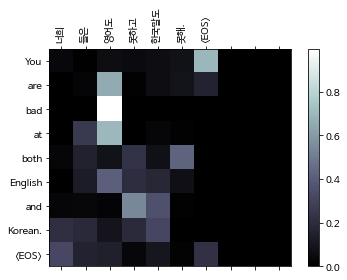

20m 40s (- 13m 1s) (46000 61%) 0.0418
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


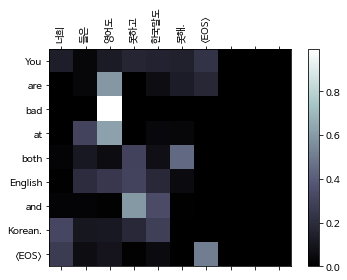

21m 6s (- 12m 34s) (47000 62%) 0.0283
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


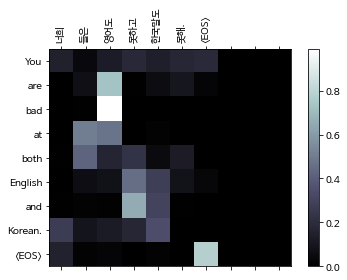

21m 33s (- 12m 7s) (48000 64%) 0.0392
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


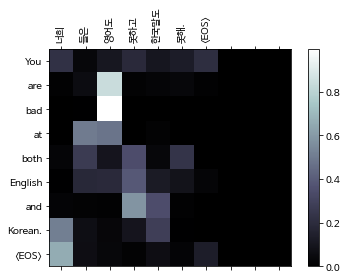

21m 59s (- 11m 40s) (49000 65%) 0.0357
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


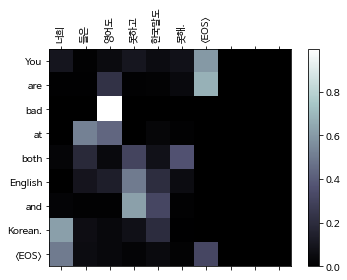

22m 27s (- 11m 13s) (50000 66%) 0.0277
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


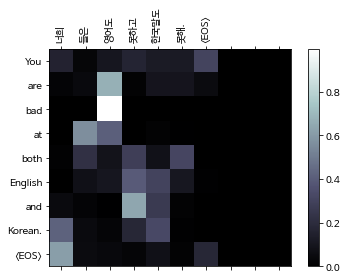

22m 53s (- 10m 46s) (51000 68%) 0.0169
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


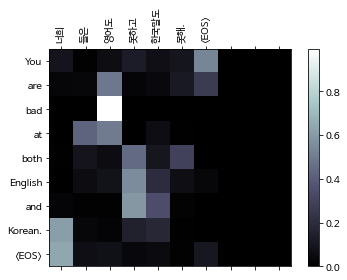

23m 20s (- 10m 19s) (52000 69%) 0.0274
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


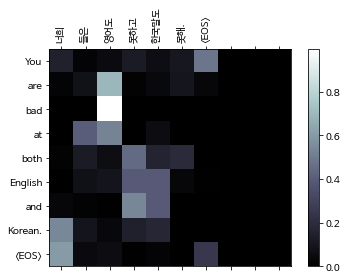

23m 46s (- 9m 52s) (53000 70%) 0.0152
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


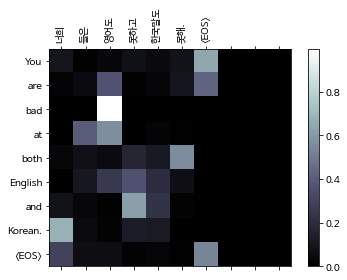

24m 12s (- 9m 24s) (54000 72%) 0.0291
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


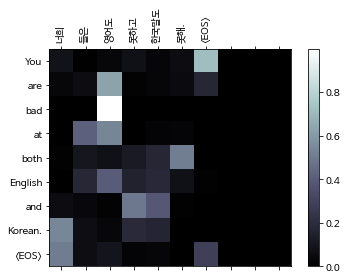

24m 39s (- 8m 57s) (55000 73%) 0.0181
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


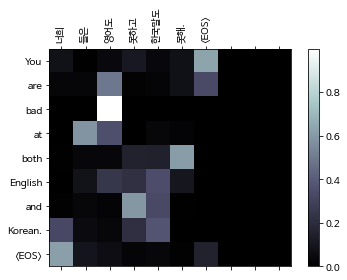

25m 5s (- 8m 30s) (56000 74%) 0.0187
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


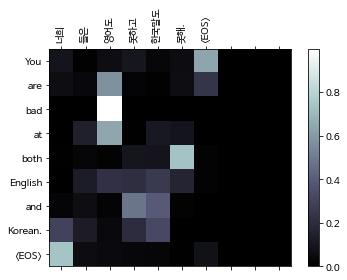

25m 30s (- 8m 3s) (57000 76%) 0.0203
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


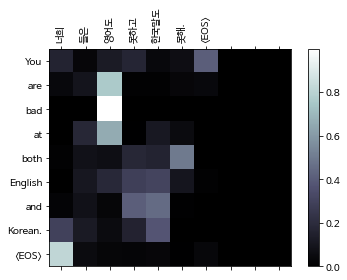

25m 56s (- 7m 36s) (58000 77%) 0.0281
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


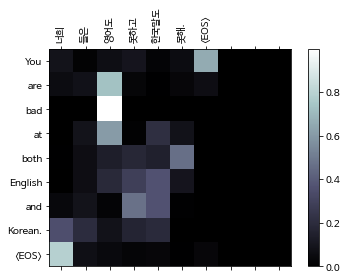

26m 21s (- 7m 8s) (59000 78%) 0.0352
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


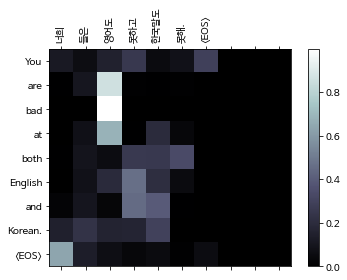

26m 47s (- 6m 41s) (60000 80%) 0.0179
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


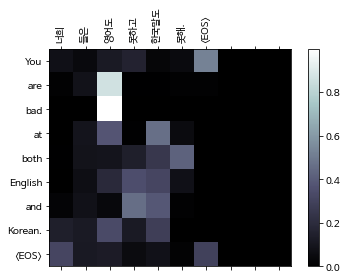

27m 15s (- 6m 15s) (61000 81%) 0.0196
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


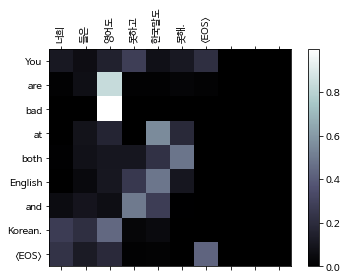

27m 40s (- 5m 48s) (62000 82%) 0.0175
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


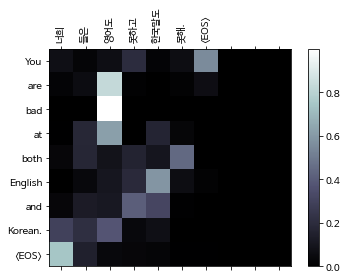

28m 6s (- 5m 21s) (63000 84%) 0.0200
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


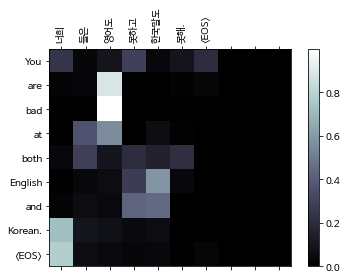

28m 32s (- 4m 54s) (64000 85%) 0.0207
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


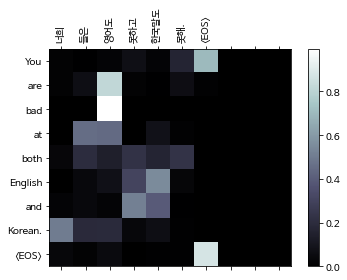

28m 58s (- 4m 27s) (65000 86%) 0.0300
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


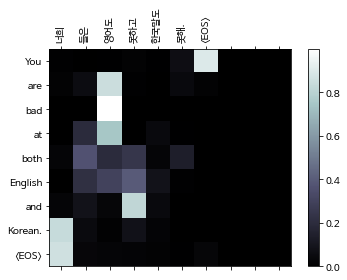

29m 25s (- 4m 0s) (66000 88%) 0.0310
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


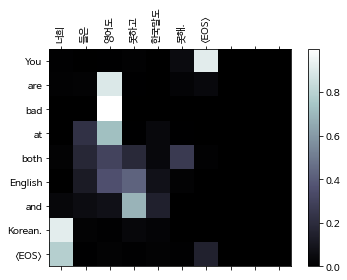

29m 51s (- 3m 33s) (67000 89%) 0.0147
input = 너희 들은 영어도 못하고 한국말도 못해.
output = I am looking for door things your message. <EOS>


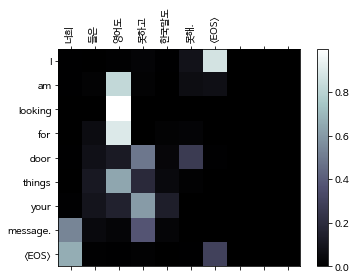

30m 16s (- 3m 7s) (68000 90%) 0.0328
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


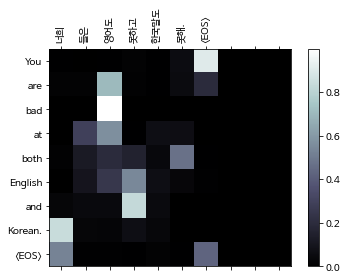

30m 42s (- 2m 40s) (69000 92%) 0.0131
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


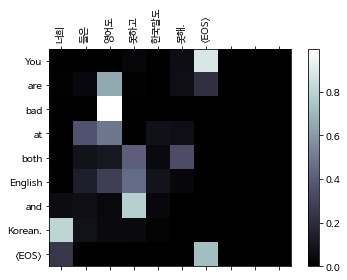

31m 8s (- 2m 13s) (70000 93%) 0.0133
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


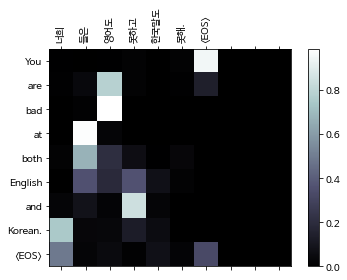

31m 35s (- 1m 46s) (71000 94%) 0.0255
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


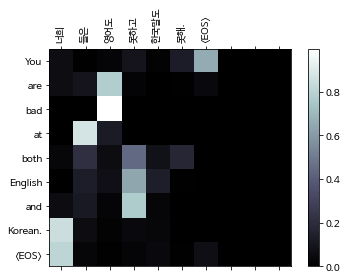

32m 0s (- 1m 20s) (72000 96%) 0.0310
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


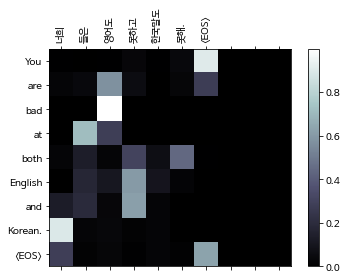

32m 26s (- 0m 53s) (73000 97%) 0.0123
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


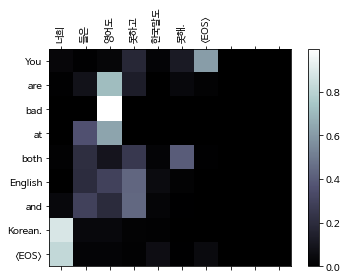

32m 52s (- 0m 26s) (74000 98%) 0.0241
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


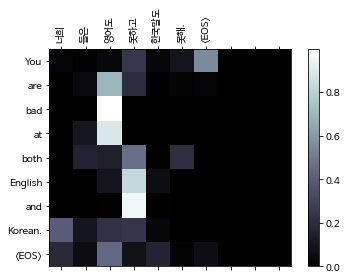

33m 17s (- 0m 0s) (75000 100%) 0.0275
input = 너희 들은 영어도 못하고 한국말도 못해.
output = You are bad at both English and Korean. <EOS>


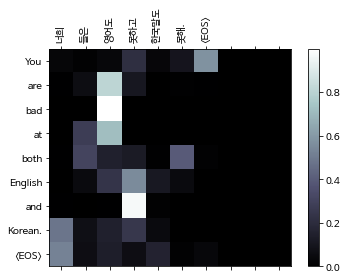

/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)


<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


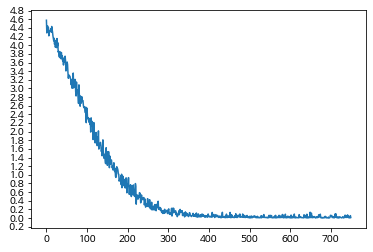

In [ ]:

%matplotlib inline
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = BahdanauDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1, score_function="general").to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=1000, learning_rate=0.0001)

1m 32s (- 6m 10s) (5000 20%) 4.1215
3m 3s (- 4m 35s) (10000 40%) 3.2490
4m 35s (- 3m 3s) (15000 60%) 2.3573
6m 7s (- 1m 31s) (20000 80%) 1.5717
7m 40s (- 0m 0s) (25000 100%) 1.0354


<Figure size 432x288 with 0 Axes>

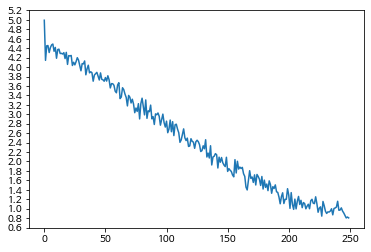

In [ ]:

%matplotlib inline
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = BahdanauDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=1000, learning_rate=0.0001)

In [ ]:
# additive
%matplotlib inline
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = BahdanauDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=1000, learning_rate=0.0001)

## 학습과 평가

이러한 모든 헬퍼 함수를 이용해서 (추가 작업처럼 보이지만 여러 실험을
더 쉽게 수행 할 수 있음) 실제로 네트워크를 초기화하고 학습을
시작할 수 있습니다.

입력 문장이 많이 필터링되었음을 기억하십시오. 이 작은 데이터 세트의
경우 256 크기의 은닉 노드(hidden node)와 단일 GRU 계층 같은 상대적으로 작은
네트워크를 사용할 수 있습니다. MacBook CPU에서 약 40분 후에
합리적인 결과를 얻을 것입니다.

.. Note::
   이 노트북을 실행하면 학습, 커널 중단, 평가를 할 수 있고 나중에
   이어서 학습을 할 수 있습니다. 인코더와 디코더가 초기화 된 행을
   주석 처리하고 ``trainIters`` 를 다시 실행하십시오.




In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

> 그는 바로 일본의 총리 대신이예요.
= He is the very prime minister of Japan.
< He is the very prime minister of Japan. <EOS>

> 레포트는 팀원들과 함께 준비 중이예요.
= I am writing a report with my team members.
< I am writing a report with my team members. <EOS>

> 우리도 비슷한 컨셉의 메뉴를 생각하고 있어.
= We are considering the similar concept of menu.
< We are considering the similar concept of menu. <EOS>

> 그녀는 진급을 못하고 일을 하고 있어.
= She is working but she's not being promoted.
< She is working but she's not being promoted. <EOS>

> 우리는 퍼포먼스 튜닝을 전문으로 해요.
= We are specialized in performance tuning.
< We are specialized in performance tuning. <EOS>

> 필리핀에 거주하기 위해 정리를 할 것이예요.
= I am preapring to live in the Phillipines.
< I am preapring to live in the Phillipines. <EOS>

> 이로 인한 불이익은 당사가 책임지지 않아요.
= We are not responsible for any disadvantages.
< We are not responsible for any disadvantages. <EOS>

> 당신이 아침을 먹었는지 아닌지가 궁금해요.
= I am curious if you ate breakfast or not.
< I am curious if you ate breakfast or not. <EOS>

> 그것들이 보통은 

### Attention 시각화

Attention 메커니즘의 유용한 속성은 하나는 해석 가능성이 높은 출력입니다.
입력 시퀀스의 특정 인코더 출력에 가중치를 부여하는 데 사용되므로
각 시간 단계에서 네트워크가 가장 집중되는 위치를 파악할 수 있습니다.

Attention 출력을 행렬로 표시하기 위해 ``plt.matshow(attentions)`` 를
간단하게 실행할 수 있습니다. 열은 입력 단계와 행이 출력 단계입니다:




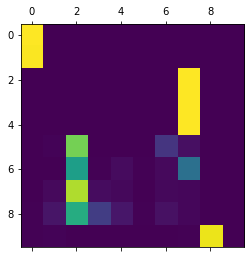

In [ ]:
%matplotlib inline
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "난 내 최고의 친구를 기다릴 준비가 돼 있어.")
plt.matshow(attentions.numpy())

더 나은 보기를 위해 축과 라벨을 더하는 추가 작업을 수행합니다:




input = 난 내 최고의 친구를 기다릴 준비가 돼 있어.
output = I am ready to wait for my best friend. <EOS>


<ipython-input-30-2c69e15d8509>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-30-2c69e15d8509>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


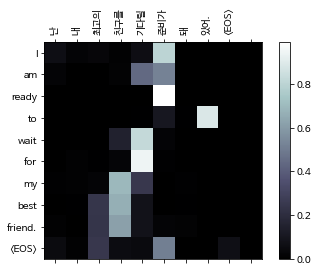

input = 그들은 이미 우리와 계약할 준비가 되어 있어요.
output = They are already prepared to sign contract with us. <EOS>


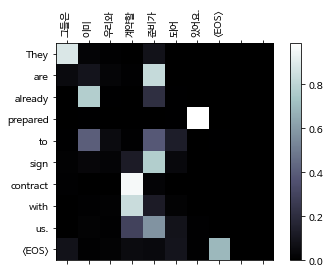

input = 이번주 수요일 당신을 점심에 초대해요.
output = You are invited to lunch this Wednesday. <EOS>


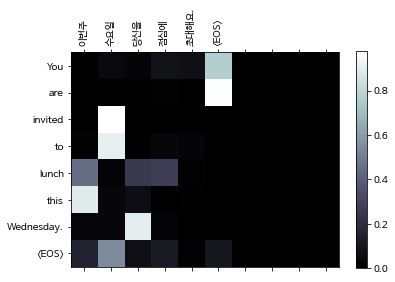

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

evaluateAndShowAttention("난 내 최고의 친구를 기다릴 준비가 돼 있어.")

evaluateAndShowAttention("그들은 이미 우리와 계약할 준비가 되어 있어요.")
evaluateAndShowAttention("이번주 수요일 당신을 점심에 초대해요.")


## 연습

-  다른 데이터 셋을 시도해 보십시오

   -  다른 언어쌍
   -  사람 → 기계 (e.g. IOT 명령어)
   -  채팅 → 응답
   -  질문 → 답변

-  word2vec 또는 GloVe 같은 미리 학습된 word embedding 으로
   embedding 을 교체하십시오

-  더 많은 레이어, 은닉 유닛, 더 많은 문장을 사용하십시오.
   학습 시간과 결과를 비교해 보십시오
-  만약 같은 구문 두개의 쌍으로 된 번역 파일을 이용한다면,
   (``I am test \t I am test``), 이것을 오토인코더로
   사용할 수 있습니다.
   이것을 시도해 보십시오:

   -  오토인코더 학습
   -  인코더 네트워크 저장하기
   -  그 상태에서 번역을 위한 새로운 디코더 학습


